# Kuzushiji T-SNE Visualization and Convolutional Neural Network (CNN)

In this notebook, I will be exploring the Kuzushiji image dataset, and demonstrating a T-SNE dimensionality reduction and exploring a Convolutional Neural Network to classify images.

We'll start below with our imports

In [1]:
#Import warnings library to filter out annoying warnings
import warnings
warnings.filterwarnings('ignore')

#Import the bread and butter 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#From SciKitLearn, import the training and testing split as well as the T-SNE library
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

#Import everything for the CNN, including the layers, optimizer function, and loss functions
import keras
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Activation,Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.losses import categorical_crossentropy, categorical_hinge

Using TensorFlow backend.


In [2]:
#Load in our images, the dataset has already split into training and testing
train_imgs = np.load('kmnist-train-imgs.npz')['arr_0']
test_imgs = np.load('kmnist-test-imgs.npz')['arr_0']
train_labels = np.load('kmnist-train-labels.npz')['arr_0']
test_labels = np.load('kmnist-test-labels.npz')['arr_0']

Kuzushiji is an ancient Japanese text that contains handwritten "Hiragana" characters. Hiragana is one of the two phoentic syllabaries of the Japanese language, the other being Katakana which is normally used for foreign words. This dataset contains samples of 10 Hiragana characters. Let's take a look at them 

In [3]:
hiragana_list = pd.read_csv('kmnist_classmap.csv', encoding = 'utf-8')
hiragana_list

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な
5,5,U+306F,は
6,6,U+307E,ま
7,7,U+3084,や
8,8,U+308C,れ
9,9,U+3092,を


These contain the letters "o,ki,su,tsu,na,ha,ma,ya,re, and wo (pronounced 'o')"

Let's visualize some of the images 

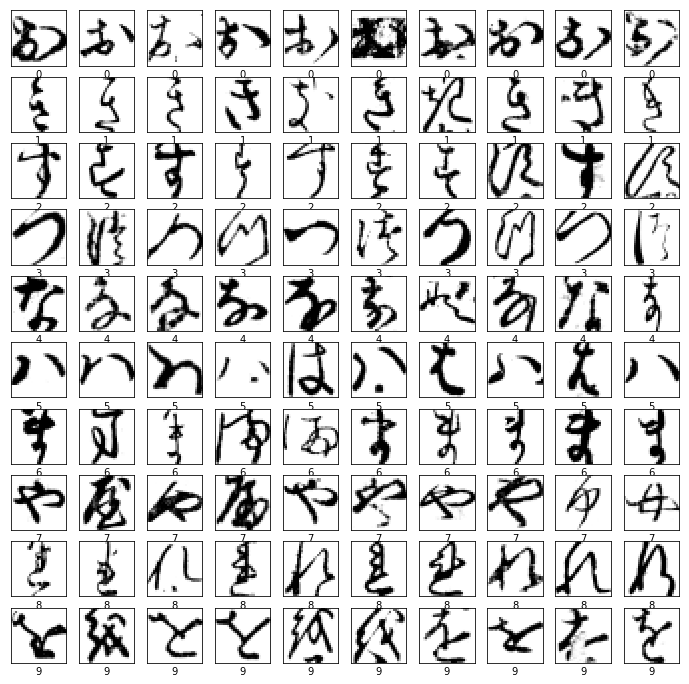

In [5]:
def plot_sample_images_data(images, labels):
    plt.figure(figsize=(12,12))
    for i in range(10):
        imgs = images[np.where(labels == i)]
        lbls = labels[np.where(labels == i)]
        for j in range(10):
            plt.subplot(10,10,i*10+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(imgs[j], cmap=plt.cm.binary)
            plt.xlabel(lbls[j])
            
plot_sample_images_data(train_imgs, train_labels)            

It's interesting to note that for the charater "ha" in row 5, we see not only the hiragana version of "ha" but also the katakana version (which looks like the first box from the left). In ancient times the characters might have been more interchangeable as formal rules hadn't been set. It is also known that originally hiragana was the symbols used by women, while katakana was used by men. 

Next, we'll begin with our T-SNE visualization. With our data being a 28x28 pixel grid, we have many dimensions to our data. T-SNE is a technique known as dimensionality reducation which aims to reduce the number of features we see in order to group more similar datapoints together in a more human understandable way. T-SNE works by mapping a probablility distribution over the original dataset in a way that takes similar datapoints and makes sure they are close to each other in the distribution. It then maps a lower dimension probability distrubtion in a way that minimizes a loss function called the "Kullback–Leibler divergence". It will then cluster similar datapoints together in lower dimensional space. 

In [8]:
#TSNE sample size 
sample_size = 9000

#Prepare data for TSNE embedding
np.random.seed(9)
idx = np.random.choice(60000, size=sample_size, replace=False)
train_sample = train_imgs.reshape(60000, -1)[idx, :]
label_sample = train_labels[idx]

# Generate 2-Dimenstional Embedding
embeddings = TSNE(perplexity=40.0, verbose=2).fit_transform(train_sample)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.477s...
[t-SNE] Computed neighbors for 9000 samples in 101.897s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 621.749648
[t-SNE] Computed conditional probabilities in 0.610s
[t-SNE] Iteration 50: error = 91.8333664, gradient norm = 0.0004119 (50 iterations in 15.371s)
[t-SNE] Iteration 100: error = 87.0443726, gradient norm = 0.0031154 (50 iterations

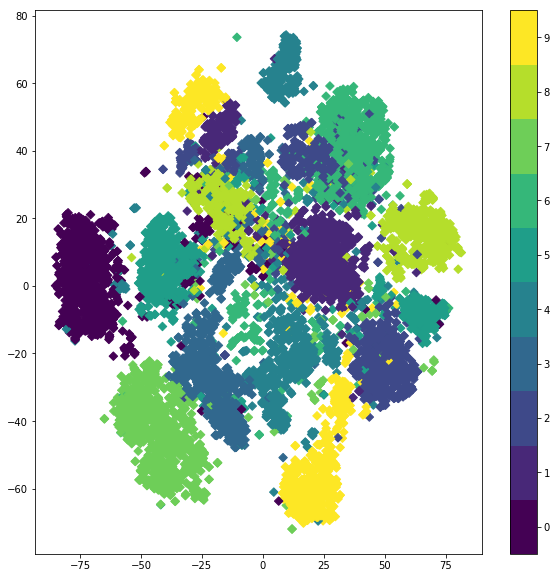

In [9]:
# Visualize using Scatterplot
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]

plt.figure(figsize=(10,10))
plt.scatter(vis_x, vis_y, c = label_sample, cmap=plt.cm.get_cmap("viridis", 10), marker='D')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

Although the visualization is not perfect, it does work to cluster our datapoints in a decent manner. Note the numbers on the color bar correspond to the index from our hiragana_list dataframe.

Next, let's prep our data for processing through a Convolutional Neural Network. After we prep our parameters and data I'll explain more about a CNN and what it is. 

In [10]:
#Hyperparameters
img_rows, img_cols = 28, 28
batch_size = 128
num_classes = 10
epochs = 10

In [11]:
def data_preprocessing(images, labels):
    out_y = keras.utils.to_categorical(labels, num_classes)
    num_images = images.shape[0]
    x_shaped_array = images.reshape(num_images, img_rows, img_cols, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

In [13]:
x, y = data_preprocessing(train_imgs, train_labels)
x_test, y_test = data_preprocessing(test_imgs, test_labels)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=9)

A Convolutional Neural Network is a type of Deep Learning algorithm that is well suited for computer vision and image classification. It works by sliding a filter over an image and uses matrix multiplication to gather data from each square it moves over. It will slide over the image and identify patterns in the data that can be learned to identify certain characteristics of each character. For example, it will identify curves and lines in certain places and it will eventually learn to map those lines and curves to particular characters. 

Let's show the layers we will be using.

In [14]:
# Model
model = Sequential()
#Add Initial Convolutional layer, normalize, add additional layer, pool, then normalize and dropout
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', padding="same",
        kernel_initializer='he_normal',input_shape=(img_rows, img_cols, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.45))

# Repeat Convolutional layers twice
model.add(Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

#Flatten data and add a fully-connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

#Final activation function
model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


We add the convolutional layers (the moving filter layers) and initialize it. Batch Normalization works to normalize each data vector, which makes each layer more independent. The pooling layer works to condense the information that the Convolutional filter finds into a a single value. For example, it might take a 2x2 matrix of data and compress it into a single value. We then add a dropout parameter to add some randomness to our data. This works to prevent our model from overfitting to our data. After our convolutions, we flatten the data into a vector, add the fully connected layer, which contains the bias and weight information to adjust our model. We finall add the softmax layer which will represent hte probablilites that will determine what character our model will guess.

With the layers of our model decided, we now choose to compile our model with an optimizer and a loss function. I'd like to try out two different loss functions and compare their results, a categorical crossentropy and a categorical hinge loss. I'll compare them on a neural network with 10 epoch (10 iterations through our training data) and whichever performs better, I'll run it through a 50 epoch network. I do this because running neural networks take a long time to run, (especially on lower grade computational hardware like I am using). 

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_train, y_train))


Train on 54000 samples, validate on 54000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
54000/54000 [==============================] - 201s 4ms/sample - loss: 0.8725 - acc: 0.7230 - val_loss: 0.2777 - val_acc: 0.9198
Epoch 2/10
54000/54000 [==============================] - 218s 4ms/sample - loss: 0.3187 - acc: 0.9014 - val_loss: 0.1172 - val_acc: 0.9646
Epoch 3/10
54000/54000 [==============================] - 229s 4ms/sample - loss: 0.2267 - acc: 0.9299 - val_loss: 0.0845 - val_acc: 0.9751
Epoch 4/10
54000/54000 [==============================] - 240s 4ms/sample - loss: 0.1824 - acc: 0.9434 - val_loss: 0.0637 - val_acc: 0.9815
Epoch 5/10
54000/54000 [==============================] - 206s 4ms/sample - loss: 0.1528 - acc: 0.9519 - val_loss: 0.0547 - val_acc: 0.9831
Epoch 6/10
54000/54000 [==============================] - 201s 4ms/sample - loss: 0.1382 - acc: 0.9573 - val_loss: 0.0436 - val_acc: 0.9873
Epoch 7/10
54000/54000 [==============================] - 203s

In [17]:
model.compile(loss='categorical_hinge',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_train, y_train))


Train on 54000 samples, validate on 54000 samples
Epoch 1/10
54000/54000 [==============================] - 295s 5ms/sample - loss: 0.0512 - acc: 0.9751 - val_loss: 0.0182 - val_acc: 0.9911
Epoch 2/10
54000/54000 [==============================] - 270s 5ms/sample - loss: 0.0503 - acc: 0.9755 - val_loss: 0.0174 - val_acc: 0.9914
Epoch 3/10
54000/54000 [==============================] - 215s 4ms/sample - loss: 0.0509 - acc: 0.9750 - val_loss: 0.0164 - val_acc: 0.9917
Epoch 4/10
54000/54000 [==============================] - 230s 4ms/sample - loss: 0.0481 - acc: 0.9765 - val_loss: 0.0185 - val_acc: 0.9910
Epoch 5/10
54000/54000 [==============================] - 203s 4ms/sample - loss: 0.0452 - acc: 0.9778 - val_loss: 0.0165 - val_acc: 0.9919
Epoch 6/10
54000/54000 [==============================] - 208s 4ms/sample - loss: 0.0458 - acc: 0.9779 - val_loss: 0.0157 - val_acc: 0.9923
Epoch 7/10
54000/54000 [==============================] - 205s 4ms/sample - loss: 0.0469 - acc: 0.9771 - val_l

Both models performed quite well. The categorical hinge had a lower validation loss as well as a higher validation accuracy. I'll run the model with categorical_hinge loss for 50 epochs. 

In [18]:
model.compile(loss='categorical_hinge',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=50,
          verbose=1,
          validation_data=(x_train, y_train))


Train on 54000 samples, validate on 54000 samples
Epoch 1/50
54000/54000 [==============================] - 211s 4ms/sample - loss: 0.0446 - acc: 0.9780 - val_loss: 0.0150 - val_acc: 0.9925
Epoch 2/50
54000/54000 [==============================] - 210s 4ms/sample - loss: 0.0478 - acc: 0.9766 - val_loss: 0.0181 - val_acc: 0.9911
Epoch 3/50
54000/54000 [==============================] - 210s 4ms/sample - loss: 0.0430 - acc: 0.9787 - val_loss: 0.0151 - val_acc: 0.9926
Epoch 4/50
54000/54000 [==============================] - 208s 4ms/sample - loss: 0.0427 - acc: 0.9787 - val_loss: 0.0154 - val_acc: 0.9924
Epoch 5/50
54000/54000 [==============================] - 201s 4ms/sample - loss: 0.0445 - acc: 0.9780 - val_loss: 0.0143 - val_acc: 0.9930
Epoch 6/50
54000/54000 [==============================] - 200s 4ms/sample - loss: 0.0431 - acc: 0.9789 - val_loss: 0.0138 - val_acc: 0.9932
Epoch 7/50
54000/54000 [==============================] - 201s 4ms/sample - loss: 0.0427 - acc: 0.9791 - val_l

The model eventually ended on a layer with less than 0.01 validation loss and a validation accuracy of 99.5%. Pretty good! 